<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/Alt_Both_Teams_Soccer_PHI_state_timeseries_w_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPUTE PHImax FOR 2 SOCCER TEAMS BASED ON 4 PLAYER DATA**

[THIS MAY BE THE LIMIT EVEN ON THE PAID PLAN]


**1. Import Data**

assuming that the files are: *Data_timeseries_1_Alex.npz* and *Data_timeseries_2_Alex.npz*

In [5]:
import numpy as np
from google.colab import files
import numpy as np

# load TEAM 1 soccer data (1= player accelerates above average)
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
data = np.load(filename)
team1_time_series_data = data['arr_0']

# load TEAM 2 data
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
data = np.load(filename)
team2_time_series_data = data['arr_0']

Saving Data_timeseries_1_Alex.npz to Data_timeseries_1_Alex (1).npz


Saving Data_timeseries_2_Alex.npz to Data_timeseries_2_Alex (1).npz


plot

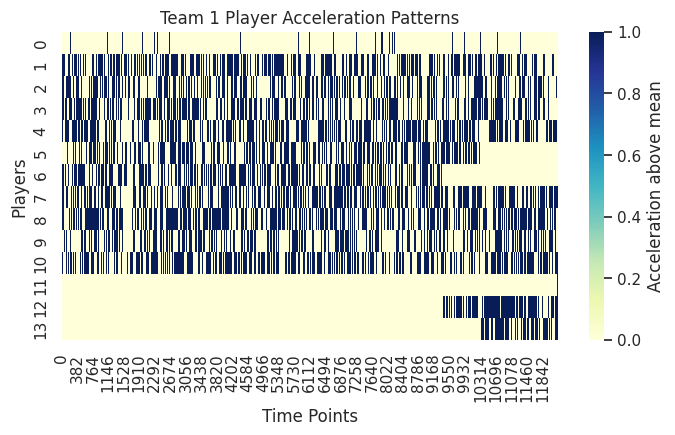

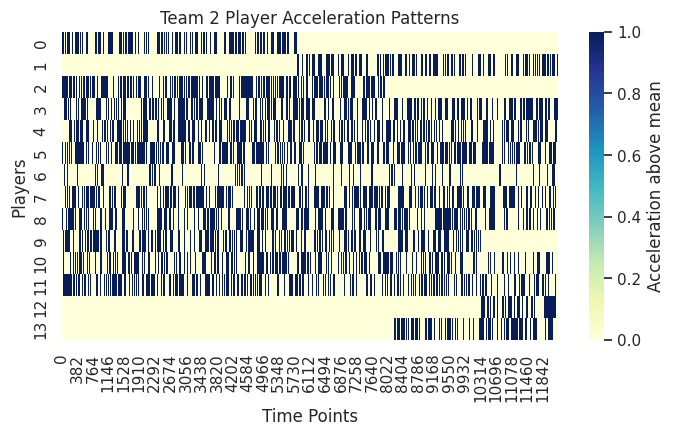

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="white")

# Creating a heatmap for Team 1
plt.figure(figsize=(8, 4))
sns.heatmap(team1_time_series_data, cmap="YlGnBu", cbar_kws={'label': 'Acceleration above mean'})
plt.title("Team 1 Player Acceleration Patterns")
plt.xlabel("Time Points")
plt.ylabel("Players")
plt.show()

# Creating a heatmap for Team 2
plt.figure(figsize=(8, 4))
sns.heatmap(team2_time_series_data, cmap="YlGnBu", cbar_kws={'label': 'Acceleration above mean'})
plt.title("Team 2 Player Acceleration Patterns")
plt.xlabel("Time Points")
plt.ylabel("Players")
plt.show()

The goalie and substitutions are clearly visible, but I have not found a good, reliable algorithm yet to tease them out, so let's hand-pick a sub-team for now

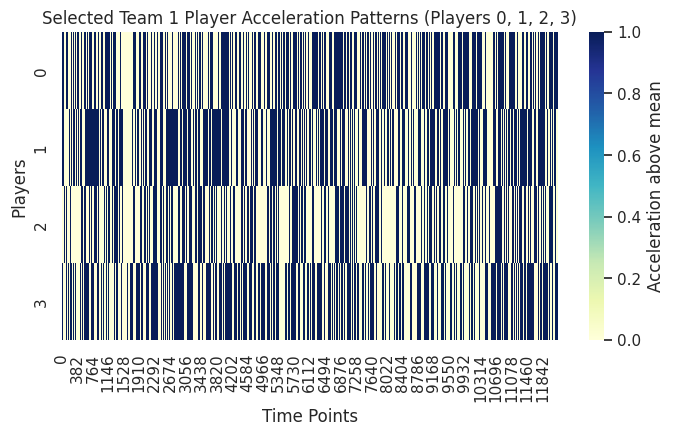

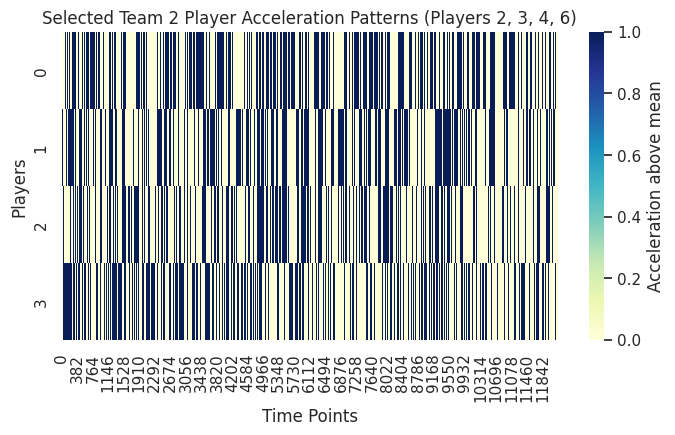

In [7]:
# Sub-selecting players using the new indices for Team 1 and Team 2
team1_new_selected_indices = [7, 8, 9, 10]
team2_new_selected_indices = [7, 8, 10, 11]

# Selecting players based on new indices
team1_selected_players_data = team1_time_series_data[team1_new_selected_indices, :]
team2_selected_players_data = team2_time_series_data[team2_new_selected_indices, :]

# Creating heatmaps for the newly selected players of Team 1 and Team 2
plt.figure(figsize=(8, 4))
sns.heatmap(team1_selected_players_data, cmap="YlGnBu", cbar_kws={'label': 'Acceleration above mean'})
plt.title("Selected Team 1 Player Acceleration Patterns (Players 0, 1, 2, 3)")
plt.xlabel("Time Points")
plt.ylabel("Players")
plt.show()

plt.figure(figsize=(8, 4))
sns.heatmap(team2_selected_players_data, cmap="YlGnBu", cbar_kws={'label': 'Acceleration above mean'})
plt.title("Selected Team 2 Player Acceleration Patterns (Players 2, 3, 4, 6)")
plt.xlabel("Time Points")
plt.ylabel("Players")
plt.show()

**Compute TPM** *THIS CODE WILL WORK FOR ANY NUMBER OF PLAYERS AND RETURN IN LITTLE ENDIAN*

In [8]:
from itertools import product
import numpy as np

def compute_transition_probability_matrix(time_series_data):
    # Infer the number of states from the data (assuming binary data, the max value + 1)
    num_states = int(np.max(time_series_data) + 1)

    # Number of players
    num_players = time_series_data.shape[0]

    # Total number of possible states (2^num_players)
    total_states = num_states ** num_players

    # Initialize the transition probability matrix with zeros
    TPM = np.zeros((total_states, total_states))

    # Dynamically generate the correct order of states
    all_states = list(product(range(num_states), repeat=num_players))
    correct_order = sorted(all_states, key=lambda x: (sum(x), x[::-1]))
    state_to_index = {state: index for index, state in enumerate(correct_order)}

    # Count the transitions
    for t in range(time_series_data.shape[1] - 1):
        current_state = tuple(time_series_data[:, t])
        next_state = tuple(time_series_data[:, t + 1])
        current_index = state_to_index[current_state]
        next_index = state_to_index[next_state]
        TPM[current_index, next_index] += 1

    # Normalize the rows to get probabilities
    for i in range(total_states):
        row_sum = np.sum(TPM[i, :])
        if row_sum > 0:
            TPM[i, :] /= row_sum

    return TPM, correct_order


# Compute the transition probability matrix
TPM1, state_list = compute_transition_probability_matrix(team1_selected_players_data)
TPM2, state_list = compute_transition_probability_matrix(team2_selected_players_data)

take a peek to double check

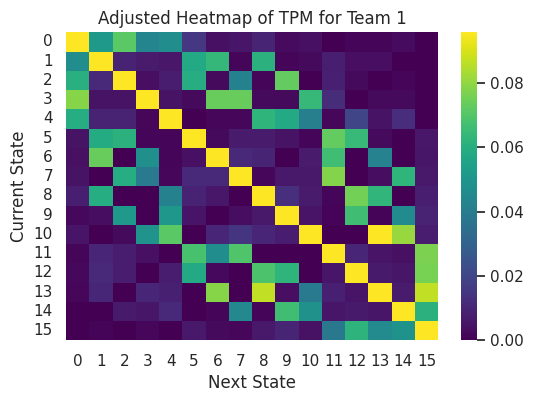

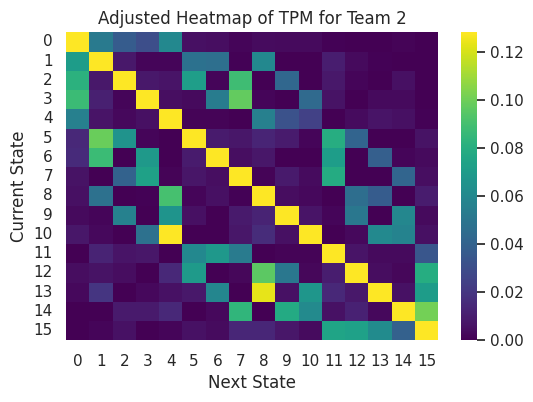

In [9]:
# Function to plot a heatmap with adjusted color scale limits
def plot_adjusted_heatmap(TPM, title, color_limit):
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(TPM, cmap='viridis', vmin=0, vmax=color_limit)
    plt.title(title)
    plt.xlabel('Next State')
    plt.ylabel('Current State')
    plt.show()

# Determining an appropriate color scale limit
# Ignoring the diagonal elements for this calculation
diagonal_ignored_TPM1 = np.copy(TPM1)
diagonal_ignored_TPM2 = np.copy(TPM2)
np.fill_diagonal(diagonal_ignored_TPM1, 0)
np.fill_diagonal(diagonal_ignored_TPM2, 0)

# Find the maximum value in the off-diagonal elements to set as the color limit
color_limit1 = np.max(diagonal_ignored_TPM1)
color_limit2 = np.max(diagonal_ignored_TPM2)

# Plotting adjusted heatmaps for both Team 1 and Team 2
plot_adjusted_heatmap(TPM1, 'Adjusted Heatmap of TPM for Team 1', color_limit1)
plot_adjusted_heatmap(TPM2, 'Adjusted Heatmap of TPM for Team 2', color_limit2)

**Launch PiPhy and compute PHI values**

In [10]:
!pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

# Check if a result file already exists to save time
if not os.path.exists('alt_team1_phi_results.pkl'):

  # Record the start time
  start_time = time.time()

  # Setting up the required parameters for pyPhi analysis
  labels = ('A', 'B', 'C', 'D')
  num_bits = len(labels)
  possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

  # Function to calculate phi values and states for a single TPM, tracking skipped trials
  def calculate_phi_for_tpm(tpm, possible_states, labels):
      converted_tpm = pyphi.convert.sbs2sbn(tpm)
      network = pyphi.Network(converted_tpm, node_labels=labels)
      node_indices = (0, 1, 2, 3)

      phi_values = np.zeros(len(possible_states))
      phi_states = np.zeros((len(possible_states), 4), dtype=int)

      max_phi = -np.inf
      max_phi_state = None
      phi_mechanisms = []

      for i, state in enumerate(possible_states):
            candidate_system = pyphi.Subsystem(network, state, node_indices)
            phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
            big_phi = phi_structure.big_phi
            phi_values[i] = big_phi
            phi_states[i] = state
            current_state_mechanisms = [distinction.mechanism for distinction in phi_structure.distinctions]
            phi_mechanisms.append(current_state_mechanisms)
            if big_phi > max_phi:
                max_phi = big_phi
                max_phi_state = state

      return phi_values, phi_states, max_phi, max_phi_state, phi_mechanisms

  # Calculate phi values
  team1_phi_results = calculate_phi_for_tpm(TPM1, possible_states, labels)
  team1_phi_values = team1_phi_results[0]
  team1_phi_states = team1_phi_results[1]
  team1_max_phi = team1_phi_results[2]
  team1_max_phi_state = team1_phi_results[3]
  team1_phi_mechanisms = team1_phi_results[4]

  # Saving the results and the list of skipped trials
  with open('alt_team1_phi_results.pkl', 'wb') as file:
    pickle.dump(team1_phi_results, file)

  # Record the end time and calculate duration
  end_time = time.time()
  elapsed_time = end_time - start_time
  # Convert elapsed time into hours, minutes, and seconds
  hours = int(elapsed_time // 3600)
  minutes = int((elapsed_time % 3600) // 60)
  seconds = elapsed_time % 60

  elapsed_time_formatted = f"{hours} hours, {minutes} minutes, {seconds:.2f} seconds"

  print(f"Elapsed time for PHI computation: {elapsed_time_formatted}")

else:
    print("File 'alt_team1_phi_results.pkl' already exists. Skipping computation.")

  Cloning https://github.com/wmayner/pyphi.git (to revision feature/iit-4.0) to /tmp/pip-req-build-4canin01
  Running command git clone --filter=blob:none --quiet https://github.com/wmayner/pyphi.git /tmp/pip-req-build-4canin01
  Resolved https://github.com/wmayner/pyphi.git to commit 83e887db466ed0c617cfb637f94a13d2aae8eea2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━

2023-12-22 20:55:43,425	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Elapsed time for PHI computation: 0 hours, 7 minutes, 49.56 seconds


Do it **AGAIN** for the other team

In [11]:
!pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

# Check if a result file already exists to save time
if not os.path.exists('alt_team2_phi_results.pkl'):

  # Record the start time
  start_time = time.time()

  # Setting up the required parameters for pyPhi analysis
  labels = ('A', 'B', 'C', 'D')
  num_bits = len(labels)
  possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

  # Function to calculate phi values and states for a single TPM, tracking skipped trials
  def calculate_phi_for_tpm(tpm, possible_states, labels):
      converted_tpm = pyphi.convert.sbs2sbn(tpm)
      network = pyphi.Network(converted_tpm, node_labels=labels)
      node_indices = (0, 1, 2, 3)

      phi_values = np.zeros(len(possible_states))
      phi_states = np.zeros((len(possible_states), 4), dtype=int)

      max_phi = -np.inf
      max_phi_state = None
      phi_mechanisms = []

      for i, state in enumerate(possible_states):
            candidate_system = pyphi.Subsystem(network, state, node_indices)
            phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
            big_phi = phi_structure.big_phi
            phi_values[i] = big_phi
            phi_states[i] = state
            current_state_mechanisms = [distinction.mechanism for distinction in phi_structure.distinctions]
            phi_mechanisms.append(current_state_mechanisms)
            if big_phi > max_phi:
                max_phi = big_phi
                max_phi_state = state

      return phi_values, phi_states, max_phi, max_phi_state, phi_mechanisms

  # Calculate phi values
  team2_phi_results = calculate_phi_for_tpm(TPM2, possible_states, labels)
  team2_phi_values = team2_phi_results[0]
  team2_phi_states = team2_phi_results[1]
  team2_max_phi = team2_phi_results[2]
  team2_max_phi_state = team2_phi_results[3]
  team2_phi_mechanisms = team2_phi_results[4]

  # Saving the results and the list of skipped trials
  with open('alt_team2_phi_results.pkl', 'wb') as file:
    pickle.dump(team2_phi_results, file)

  # Record the end time and calculate duration
  end_time = time.time()
  elapsed_time = end_time - start_time
  # Convert elapsed time into hours, minutes, and seconds
  hours = int(elapsed_time // 3600)
  minutes = int((elapsed_time % 3600) // 60)
  seconds = elapsed_time % 60

  elapsed_time_formatted = f"{hours} hours, {minutes} minutes, {seconds:.2f} seconds"

  print(f"Elapsed time for PHI computation: {elapsed_time_formatted}")

else:
    print("File 'alt_team2_phi_results.pkl' already exists. Skipping computation.")

  Cloning https://github.com/wmayner/pyphi.git (to revision feature/iit-4.0) to /tmp/pip-req-build-f9u8s8ti
  Running command git clone --filter=blob:none --quiet https://github.com/wmayner/pyphi.git /tmp/pip-req-build-f9u8s8ti
  Resolved https://github.com/wmayner/pyphi.git to commit 83e887db466ed0c617cfb637f94a13d2aae8eea2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Elapsed time for PHI computation: 0 hours, 7 minutes, 45.06 seconds


quick plot

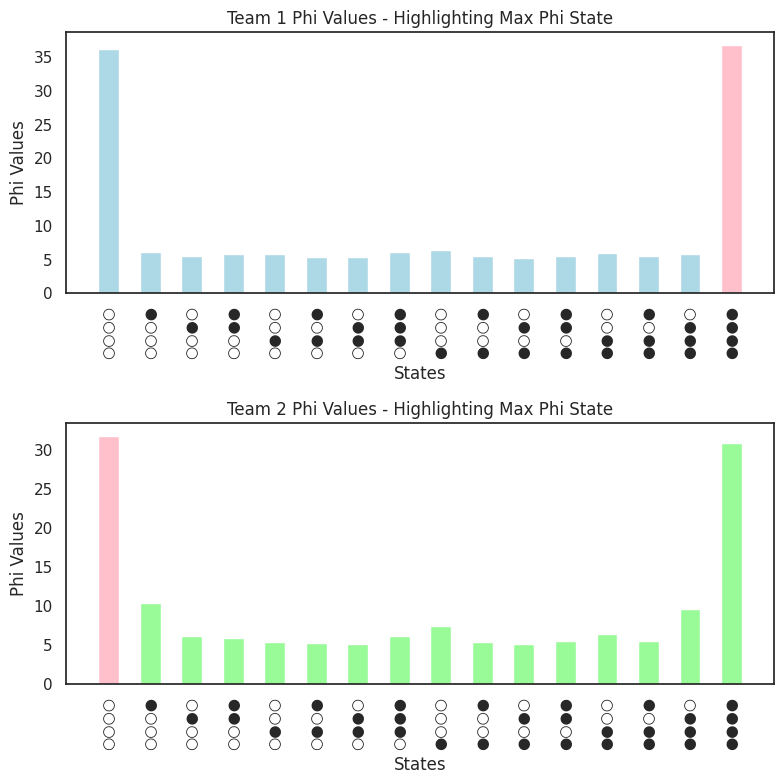

In [12]:
import matplotlib.pyplot as plt

team1_phi_values = team1_phi_results[0]
team1_phi_states = team1_phi_results[1]
team1_max_phi = team1_phi_results[2]
team1_max_phi_state = team1_phi_results[3]
team1_phi_mechanisms = team1_phi_results[4]

team2_phi_values = team2_phi_results[0]
team2_phi_states = team2_phi_results[1]
team2_max_phi = team2_phi_results[2]
team2_max_phi_state = team2_phi_results[3]
team2_phi_mechanisms = team2_phi_results[4]


# Convert states to symbolic representations for labeling
state_labels = [''.join('●' if bit == 1 else '○' for bit in state) for state in team1_phi_states]

# Convert max_phi_state to the same symbolic representation
team1_max_phi_state_label = ''.join('●' if bit == 1 else '○' for bit in team1_max_phi_state)
team2_max_phi_state_label = ''.join('●' if bit == 1 else '○' for bit in team2_max_phi_state)

# Define pastel colors
pastel_color_team1 = '#ADD8E6'  # Light blue for Team 1
pastel_color_team2 = '#98FB98'  # Pastel green for Team 2
highlight_color = '#FFC0CB'  # Pastel red for highlighting max phi

# Creating the plot with two subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot for Team 1
for state_label, phi_value in zip(state_labels, team1_phi_values):
    color = highlight_color if state_label == team1_max_phi_state_label else pastel_color_team1
    axs[0].bar(state_label, phi_value, width=0.5, color=color)

# Plot for Team 2
for state_label, phi_value in zip(state_labels, team2_phi_values):
    color = highlight_color if state_label == team2_max_phi_state_label else pastel_color_team2
    axs[1].bar(state_label, phi_value, width=0.5, color=color)

# Setting titles and labels for Team 1 plot
axs[0].set_title('Team 1 Phi Values - Highlighting Max Phi State')
axs[0].set_xlabel('States')
axs[0].set_ylabel('Phi Values')
axs[0].set_xticks(np.arange(len(state_labels)))
axs[0].set_xticklabels(state_labels, rotation=90)

# Setting titles and labels for Team 2 plot
axs[1].set_title('Team 2 Phi Values - Highlighting Max Phi State')
axs[1].set_xlabel('States')
axs[1].set_ylabel('Phi Values')
axs[1].set_xticks(np.arange(len(state_labels)))
axs[1].set_xticklabels(state_labels, rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Re-Map PHI to the state-by-state time series

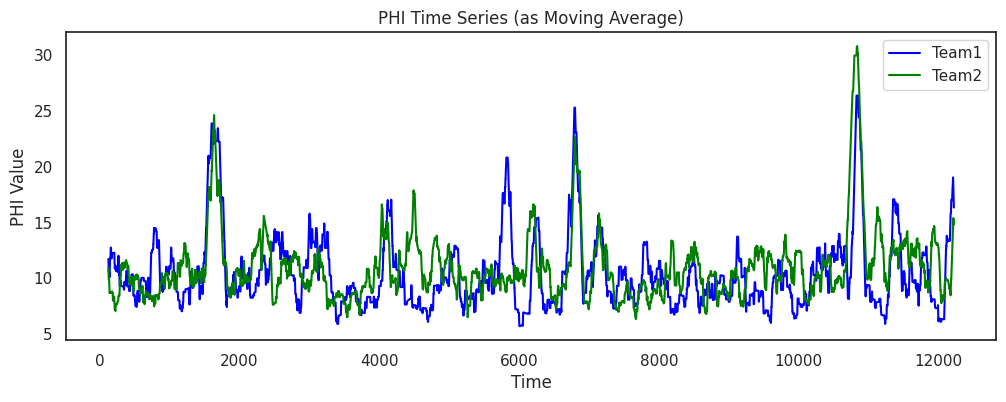

In [13]:
# Extracting the necessary data from phi_results
team1_phi_values = team1_phi_results[0]
team1_phi_states = team1_phi_results[1]
team2_phi_values = team2_phi_results[0]
team2_phi_states = team2_phi_results[1]

# Mapping each state to its corresponding phi value
team1_state_to_phi = {tuple(state): phi for state, phi in zip(team1_phi_states, team1_phi_values)}
team2_state_to_phi = {tuple(state): phi for state, phi in zip(team2_phi_states, team2_phi_values)}

# Reassigning the phi values to the respective states in the original time series sequence
team1_phi_time_series = np.array([team1_state_to_phi[tuple(state)] for state in team1_selected_players_data.T])
team2_phi_time_series = np.array([team2_state_to_phi[tuple(state)] for state in team2_selected_players_data.T])

# Compute a moving average of the phi time series
window_size = 128  # Define the window size for the moving average
team1_moving_avg = np.convolve(team1_phi_time_series, np.ones(window_size) / window_size, mode='valid')
team2_moving_avg = np.convolve(team2_phi_time_series, np.ones(window_size) / window_size, mode='valid')

# Plotting the time series of PHI values and the moving average
plt.figure(figsize=(12, 4))
plt.plot(np.arange(window_size - 1, len(team1_phi_time_series)), team1_moving_avg, label='Team1', color='blue')
plt.plot(np.arange(window_size - 1, len(team2_phi_time_series)), team2_moving_avg, label='Team2', color='green')
plt.title('PHI Time Series (as Moving Average)')
plt.xlabel('Time')
plt.ylabel('PHI Value')
plt.legend()
plt.show()

MECHANISMS (and ARITY) over time

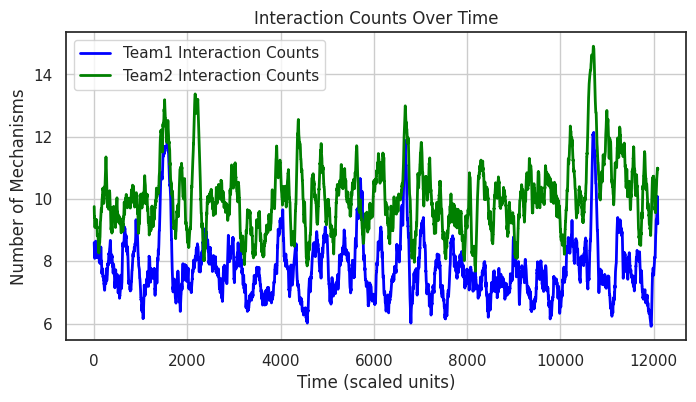

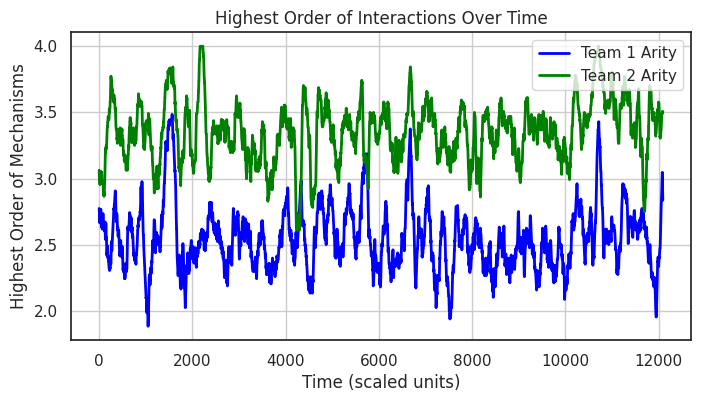

In [20]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

team1_phi_mechanisms = team1_phi_results[4]
team1_phi_states = team1_phi_results[1]

team2_phi_mechanisms = team2_phi_results[4]
team2_phi_states = team2_phi_results[1]

team1_state_to_index = {tuple(state): index for index, state in enumerate(team1_phi_states)}
team2_state_to_index = {tuple(state): index for index, state in enumerate(team2_phi_states)}

# Function to determine the highest order of mechanism
def highest_order(mechanisms):
    return max(len(m) for m in mechanisms) if mechanisms else 0

# Map the number of mechanisms and their highest orders to the original time series
team1_mechanism_counts = [len(team1_phi_mechanisms[team1_state_to_index[tuple(state)]]) for state in team1_selected_players_data.T]
team1_highest_orders = [highest_order(team1_phi_mechanisms[team1_state_to_index[tuple(state)]]) for state in team1_selected_players_data.T]
team2_mechanism_counts = [len(team2_phi_mechanisms[team2_state_to_index[tuple(state)]]) for state in team2_selected_players_data.T]
team2_highest_orders = [highest_order(team2_phi_mechanisms[team2_state_to_index[tuple(state)]]) for state in team2_selected_players_data.T]

# Maximum order among all mechanisms
max_order = max(team1_highest_orders)

# Define a custom colormap
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink']  # For orders 1, 2, 3, ...
cmap = mcolors.ListedColormap(colors[:max_order])

# Normalize highest order for color mapping
norm = plt.Normalize(1, max_order)

# Calculate moving averages
window_size = 128  # Window size for moving averages
team1_moving_avg_mechanism_counts = np.convolve(team1_mechanism_counts, np.ones(window_size)/window_size, mode='valid')
team1_moving_avg_highest_orders = np.convolve(team1_highest_orders, np.ones(window_size)/window_size, mode='valid')
team2_moving_avg_mechanism_counts = np.convolve(team2_mechanism_counts, np.ones(window_size)/window_size, mode='valid')
team2_moving_avg_highest_orders = np.convolve(team2_highest_orders, np.ones(window_size)/window_size, mode='valid')

# Define time_span as the range of time points in the original time series
time_span = np.arange(len(team1_selected_players_data.T))

# Plot 1: Interaction Counts
fig1, ax1 = plt.subplots(figsize=(8, 4))

# Plotting moving average of mechanism counts
ax1.plot(time_span[:len(team1_moving_avg_mechanism_counts)], team1_moving_avg_mechanism_counts, color='blue', linewidth=2, label='Team1 Interaction Counts')
ax1.plot(time_span[:len(team2_moving_avg_mechanism_counts)], team2_moving_avg_mechanism_counts, color='green', linewidth=2, label='Team2 Interaction Counts')

# Set labels and titles for Plot 1
ax1.set_title("Interaction Counts Over Time")
ax1.set_xlabel("Time (scaled units)")
ax1.set_ylabel("Number of Mechanisms")
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot 2: Arity/Order
fig2, ax2 = plt.subplots(figsize=(8, 4))

# Plotting moving average of highest orders
ax2.plot(time_span[:len(team1_moving_avg_highest_orders)], team1_moving_avg_highest_orders, color='blue', linewidth=2, label='Team 1 Arity')
ax2.plot(time_span[:len(team2_moving_avg_highest_orders)], team2_moving_avg_highest_orders, color='green', linewidth=2, label='Team 2 Arity')

# Set labels and titles for Plot 2
ax2.set_title("Highest Order of Interactions Over Time")
ax2.set_xlabel("Time (scaled units)")
ax2.set_ylabel("Highest Order of Mechanisms")
ax2.grid(True)
ax2.legend(loc='upper right')

plt.show()

Check correlations

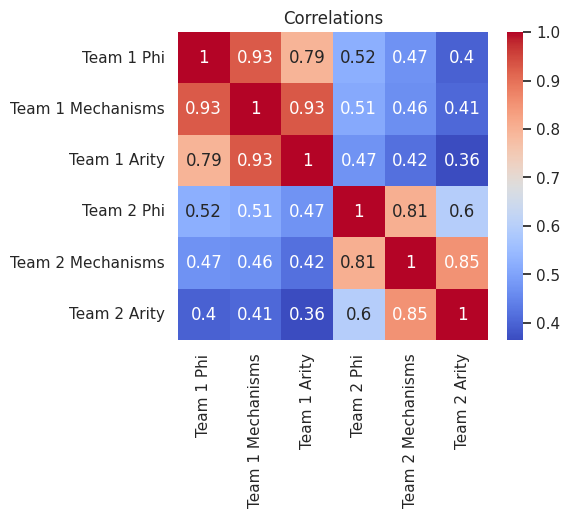

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Team1
team1_moving_avg_phi = team1_moving_avg
team1_min_length = min(len(team1_moving_avg_phi), len(team1_moving_avg_mechanism_counts), len(team1_moving_avg_highest_orders))
team1_moving_avg_phi = team1_moving_avg_phi[:team1_min_length]
team1_moving_avg_mechanism_counts = team1_moving_avg_mechanism_counts[:team1_min_length]
team1_moving_avg_highest_orders = team1_moving_avg_highest_orders[:team1_min_length]

# Team2
team2_moving_avg_phi = team2_moving_avg
team2_min_length = min(len(team2_moving_avg_phi), len(team2_moving_avg_mechanism_counts), len(team2_moving_avg_highest_orders))
team2_moving_avg_phi = team2_moving_avg_phi[:team1_min_length]
team2_moving_avg_mechanism_counts = team2_moving_avg_mechanism_counts[:team2_min_length]
team2_moving_avg_highest_orders = team2_moving_avg_highest_orders[:team2_min_length]

# Concatenating the data for both teams
combined_data = np.array([
    team1_moving_avg_phi,
    team1_moving_avg_mechanism_counts,
    team1_moving_avg_highest_orders,
    team2_moving_avg_phi,
    team2_moving_avg_mechanism_counts,
    team2_moving_avg_highest_orders
])

# Compute the correlation matrix for the combined data
correlation_matrix = np.corrcoef(combined_data)

# Plotting the correlation matrix
plt.figure(figsize=(5, 4)) # Adjust size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            xticklabels=['Team 1 Phi', 'Team 1 Mechanisms', 'Team 1 Arity', 'Team 2 Phi', 'Team 2 Mechanisms', 'Team 2 Arity'],
            yticklabels=['Team 1 Phi', 'Team 1 Mechanisms', 'Team 1 Arity', 'Team 2 Phi', 'Team 2 Mechanisms', 'Team 2 Arity'])
plt.title('Correlations')
plt.show()